# Fraudulent User Detection Using Amazon Dataset
### Penghao Xu, Yuan Chen, Jiawei Wu, Haojing Lu

## Part 3. Proposed New Methods

This script is used to apply our proposed new model to fraudulent user detection on Amazon review dataset.


In [34]:
import numpy as np
import pandas as pd
import torch
from torch import nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve, auc

torch.manual_seed(3407)

In [2]:
datafile = f'dataset/toy_3-core_80_20_test_embedding.csv'
labelfile = f'dataset/toy_user_label.csv'

In [3]:
# check cuda availablity
if torch.cuda.is_available():
    device = torch.device('cuda')
    torch.cuda.empty_cache()
else:
    device = torch.device('cpu')
    
device

device(type='cuda')

### Load data
Here, we load all scores and embeddings and group them in each user

In [4]:
# load labels and sort in users order
with open(labelfile, 'r') as fr:
    fr.readline()
    user_labels = []
    for l in fr:
        ws = l.rstrip('\n').split(',')
        user_labels.append((ws[0], float(ws[1])))
    user_labels.sort()
    user_labels = torch.tensor([x[1] for x in user_labels]).to(device)

# load data and group by products
with open(datafile, 'r') as fr:
    data = {}
    for l in fr:
        ws = l.rstrip('\n').split(',')
        emb_dim = len(ws) - 2
        if ws[1] not in data:
            data[ws[1]] = []
        data[ws[1]].append([ws[0], ws[1], torch.tensor([float(x) for x in ws[2:]])])
print(f'Total users: {len(user_labels)}')
print(user_labels[0])
print(f'Total products: {len(data)}')
print(data['0001055178'])

Total users: 12734
tensor(0.8889, device='cuda:0')
Total products: 18525
[['A14CC5FIPR5YVF', '0001055178', tensor([0.5000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000])], ['A19D816DMGI44L', '0001055178', tensor([1., 1., 1., 1., 1., 1., 1., 1., 1.])], ['A12RI2CLUGCZ26', '0001055178', tensor([0.5000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000])]]


### Build model
This model takes the text embeddings and scores to predict the user helpfulness and detect fraudulent users using the following formula:

$$
\overrightarrow{G(p)} = AGG(RNN(\overrightarrow{S(u, p)}, \forall u \in U),  \Pi_p)
$$
$$
\overrightarrow{R(u, p)} = NN(\overrightarrow{S(u, p)}, \overrightarrow{G(p)})
$$
$$
F(u) = AGG(\overrightarrow{R(u, p)}, \forall p \in P, \overrightarrow{\Pi_u}) 
$$

In this very first model, the product and user embeddings are removed. We used the following formula:
$$
\overrightarrow{G(p)} = GRU(\overrightarrow{S(u, p)}, \forall u \in U)
$$
$$
\overrightarrow{R(u, p)} = NN(\overrightarrow{S(u, p)}, \overrightarrow{G(p)})
$$
$$
F(u) = GRU(\overrightarrow{R(u, p)}, \forall p \in P) 
$$

In [5]:
# helper function to convert text embeddings of a product
def emb2tensor(data, dim):
    product = data[0][1]
    tensor = torch.zeros((len(data), 1, dim))
    for i, d in enumerate(data):
        tensor[i,:,:] = d[-1]
    return tensor, product
emb2tensor(data['0001055178'], emb_dim)

(tensor([[[0.5000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
           1.0000]],
 
         [[1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
           1.0000]],
 
         [[0.5000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
           1.0000]]]),
 '0001055178')

In [6]:
class FUD(nn.Module):
    def __init__(self, emb_dim, device):
        super().__init__()
        # get parameters
        self.dim = emb_dim
        # set layers
        self.GRU = nn.GRU(emb_dim, 32)
        self.fc1 = nn.Linear(emb_dim + 32, 16)
        self.fc2 = nn.Linear(16, 16)
        self.GRU2 = nn.GRU(16, 1)
        self.device = device
    
    def forward(self, x):
        # calculate gp
        gp = {}
        for su in x.values():
            tensor, p = emb2tensor(su, self.dim)
            gp[p] = self.GRU(tensor.to(self.device))[-1].view(-1)
        # calculate rup
        rup = {}
        for su in x.values():
            for r in su:
                u, p, s = r
                s = torch.cat((s.to(device), gp[p]))
                if u not in rup:
                    rup[u] = []
                rup[u].append(self.fc2(F.relu(self.fc1(s))))
        # fairness for users
        fu = []
        for u in sorted(rup.keys()):
            v = torch.stack(rup[u], dim=1).view(len(rup[u]), 1, 16)
            fu.append(self.GRU2(v)[-1])
        return torch.cat(fu)

### Train model

In [45]:
model = FUD(emb_dim, device).to(device)
model

FUD(
  (GRU): GRU(9, 32)
  (fc1): Linear(in_features=41, out_features=16, bias=True)
  (fc2): Linear(in_features=16, out_features=16, bias=True)
  (GRU2): GRU(16, 1)
)

In [46]:
optimizer = torch.optim.SGD(model.parameters(), lr=1e-2, weight_decay=1e-7)
criterion = nn.MSELoss()
epochs = 25
report_epoch = 5
losses = []

for i in range(epochs):
    model.train()
    y_pred = model(data)
    loss = criterion(y_pred.view(-1), user_labels)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    losses.append(loss.view(-1).cpu().detach().numpy()[0])
    if not i % report_epoch:
        print(f'Epoch {i}, MSE Loss: {losses[-1]}')

Epoch 0, MSE Loss: 2.4350361824035645
Epoch 5, MSE Loss: 1.4469670057296753
Epoch 10, MSE Loss: 0.39731350541114807
Epoch 15, MSE Loss: 0.1689154952764511
Epoch 20, MSE Loss: 0.10827644169330597


Save model weights if needed

In [47]:
torch.save(model.state_dict(), 'Model_weights.tar')

Visualize training process

Text(0.5, 1.0, 'Training process')

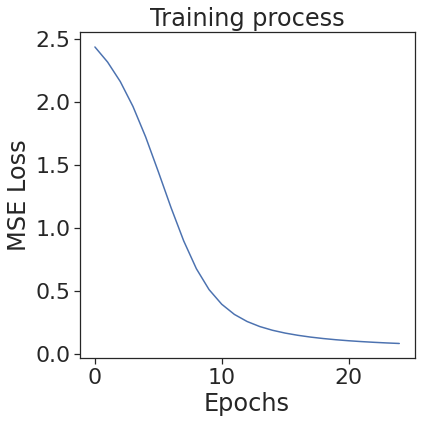

In [48]:
fig, ax = plt.subplots(figsize=(6,6))
sns.set(style='ticks', font_scale=2)
plt.plot(list(range(epochs)), losses)
plt.ylabel('MSE Loss')
plt.xlabel('Epochs')
plt.title('Training process')

Check accuracy

In [49]:
# generate labels
labels = user_labels.cpu().detach().numpy()
labels[labels>0.5] = 1
labels[labels<0.5] = 0

In [50]:
threshold = 0.1
preds = y_pred.view(-1).cpu().detach().numpy()
preds[preds > threshold] = 1
preds[preds < threshold] = 0
acc = np.sum(preds == labels)/len(preds)
print(f'Accuracy: {acc:.4f}')

Accuracy: 0.9351


ROC curve and AUC

Text(0.5, 1.0, 'ROC curve\n AUC:0.6273')

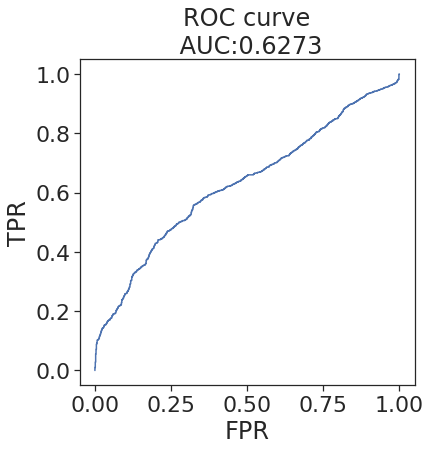

In [51]:
fpr, tpr, _ = roc_curve(labels, y_pred.view(-1).cpu().detach().numpy())
roc_auc = auc(fpr, tpr)
fig, ax = plt.subplots(figsize=(6,6))
sns.set(style='ticks', font_scale=2)
plt.plot(fpr, tpr)
plt.ylabel('TPR')
plt.xlabel('FPR')
plt.title(f'ROC curve\n AUC:{roc_auc:.4f}')